# Importing needed libraries

In [5]:
import os
import glob
import numpy as np
import cv2 
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.ops import FeaturePyramidNetwork
from torchvision.ops.feature_pyramid_network import LastLevelMaxPool
from collections import OrderedDict
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as Functional
import torchvision.models as models
import torch.optim as optim
from tqdm import tqdm
import matplotlib.image as mpimg
import random
import matplotlib.pyplot as plt
from numpy import linalg as LA
import math
import matplotlib.cm as cm
from scipy.signal import convolve2d

# Q1

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### importing Cat dataset and apply transformations

In [7]:
class Load_data_class(Dataset):
    def __init__(self, path, tFunction):
        self.path = path
        self.tFunction = tFunction
        self.images = []
        self.annotations = []
        self.p = 1

        for i in range(7):
            folder = os.path.join(path, f"CAT_0{i}")
            images = glob.glob(os.path.join(folder, "*.jpg"))
            self.images.extend(images)
            self.annotations.extend([f + ".cat" for f in images])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        annotation_path = self.annotations[idx]

        image = Image.open(image_path).convert("RGB")
        
        if self.tFunction:
            transformed_image = self.tFunction(image)
            w, h = image.size

            with open(annotation_path, 'r') as file:
                points = np.array([float(coord) for coord in file.read().split()[1:]]).reshape(-1)                
                points[::2] *= (224 / w)
                points[1::2] *= (224 / h)
                
                if self.p==1:
                    print(points.shape)
                    self.p += 1

            
            points_tensor = torch.tensor(points, dtype=torch.float)

        return {'image': transformed_image, 'points': points_tensor}

In [8]:
tFunction = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
data = Load_data_class('/kaggle/input/cat-dataset', tFunction)

train, test = train_test_split(list(range(len(data))), test_size=0.2, random_state=24)

In [10]:
data_train = Subset(data, train)
data_test = Subset(data, test)

In [11]:
trainLoader = DataLoader(data_train, batch_size=32, shuffle=True, num_workers=4)
testLoader = DataLoader(data_test, batch_size=32, shuffle=False, num_workers=4)

### implementing desired detection neural network 

In [12]:
class DetectionModel(nn.Module):
    def __init__(self, num_points=9):
        super(DetectionModel, self).__init__()
        
        self.backbone = models.resnet50(pretrained=True)
 
        for param in self.backbone.parameters():
            param.requires_grad = False
            
            
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=[512, 1024, 2048], 
            out_channels=256,
            extra_blocks=LastLevelMaxPool()
        )
        
        self.resnet_head = nn.Linear(2048, 512)  
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.final_head = nn.Linear(512, num_points * 2) 

        self.fpn_head = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, num_points * 2)
        )

    def forward(self, x):
        c1 = self.backbone.layer1(self.backbone.relu(self.backbone.bn1(self.backbone.conv1(x))))
        c2 = self.backbone.layer2(c1)
        c3 = self.backbone.layer3(c2)
        c4 = self.backbone.layer4(c3)
        c5 = Functional.adaptive_avg_pool2d(c4, (1, 1)).view(c4.size(0), -1)
        
        
        x_resnet = self.resnet_head(c5)
        x_resnet = self.relu(x_resnet)
        x_resnet = self.dropout(x_resnet)
        x_resnet = self.final_head(x_resnet)

        fpn_features = OrderedDict([('c2', c2), ('c3', c3), ('c4', c4)])
        fpn_features = self.fpn(fpn_features)
        logits_fpn = []
        for feature in fpn_features.values():
            logits_fpn.append(self.fpn_head(feature))

        logits_fpn = torch.stack(logits_fpn, dim=0).mean(dim=0)
        
        return x_resnet + logits_fpn

In [13]:
model = DetectionModel(num_points=9)

#changed
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 165MB/s] 


In [14]:
if torch.cuda.is_available():
    model.to(device)

### trainig part

In [15]:
def train_model(model, train_loader, criterion, optimizer, device='cuda', num_epochs=10):
    model.train() 
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        with tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for i, sample in pbar:
                images = sample['image'].to(device)
                points = sample['points'].to(device)

                optimizer.zero_grad()

                outputs = model(images)
                loss = criterion(outputs, points.view(points.size(0), -1))
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                pbar.set_postfix({'loss': running_loss / (i + 1)})
    
    print('Finished Training')


train_model(model, trainLoader, criterion, optimizer, device=device, num_epochs=10)


Epoch 1/10:   0%|          | 0/250 [00:00<?, ?it/s]

(18,)(18,)

(18,)(18,)



Epoch 2/10:   0%|          | 0/250 [00:00<?, ?it/s]

(18,)
(18,)
(18,)(18,)



Epoch 3/10:   0%|          | 0/250 [00:00<?, ?it/s]

(18,)(18,)

(18,)
(18,)


Epoch 4/10:   0%|          | 0/250 [00:00<?, ?it/s]

(18,)(18,)

(18,)
(18,)


Epoch 5/10:   0%|          | 0/250 [00:00<?, ?it/s]

(18,)(18,)
(18,)

(18,)


Epoch 6/10:   0%|          | 0/250 [00:00<?, ?it/s]

(18,)
(18,)(18,)

(18,)


Epoch 7/10:   0%|          | 0/250 [00:00<?, ?it/s]

(18,)(18,)

(18,)(18,)



Epoch 8/10:   0%|          | 0/250 [00:00<?, ?it/s]

(18,)
(18,)(18,)

(18,)


Epoch 9/10:   0%|          | 0/250 [00:00<?, ?it/s]

(18,)
(18,)
(18,)
(18,)


Epoch 10/10:   0%|          | 0/250 [00:00<?, ?it/s]

(18,)
(18,)
(18,)
(18,)


Epoch 10/10: 100%|██████████| 250/250 [02:03<00:00,  2.02it/s, loss=8.7] 

Finished Training


### model evaulation

In [16]:
class ModelEvaluator:
    def __init__(self, model, testLoader, device='cuda'):
        self.model = model
        self.testLoader = testLoader
        self.device = device
        self.all_images = []
        self.all_ground_truth_points = []
        self.all_predicted_points = []
    
    def evaluate_model(self):
        self.model.eval()
        with torch.no_grad():
            for batch_idx, sample in enumerate(self.testLoader):
                images = sample['image'].to(self.device)
                targets = sample['points'].to(self.device)

                # Forward pass through the model to get predicted points
                predicted_points = self.model(images)

                # Store results for plotting later
                self.all_images.append(images.cpu().permute(0, 2, 3, 1).numpy())  # Convert image tensor to numpy array
                self.all_ground_truth_points.append(targets.cpu().numpy())
                self.all_predicted_points.append(predicted_points.cpu().numpy())
    
    def plot_random_image(self):

        idx = random.randint(0, len(self.all_images) - 1)
        
        image = self.all_images[idx][0] 
        ground_truth_points = self.all_ground_truth_points[idx][0]
        predicted_points = self.all_predicted_points[idx][0]

        fig, axs = plt.subplots(1, 2, figsize=(15, 7))

        axs[0].imshow(image)
        axs[0].set_title('Ground Truth Points')
        axs[0].scatter(ground_truth_points[::2], ground_truth_points[1::2], c='r', marker='o')  # assuming points are flattened [x1, y1, x2, y2, ...]
        axs[0].set_xticks([])
        axs[0].set_yticks([])

        axs[1].imshow(image)
        axs[1].set_title('Predicted Points')
        axs[1].scatter(predicted_points[::2], predicted_points[1::2], c='b', marker='o')  # assuming points are flattened [x1, y1, x2, y2, ...]
        axs[1].set_xticks([])
        axs[1].set_yticks([])

        plt.tight_layout()
        plt.show()
        
        
evaluator = ModelEvaluator(model, testLoader)
evaluator.evaluate_model()


(18,)
(18,)
(18,)
(18,)


### plotting some randome data detected

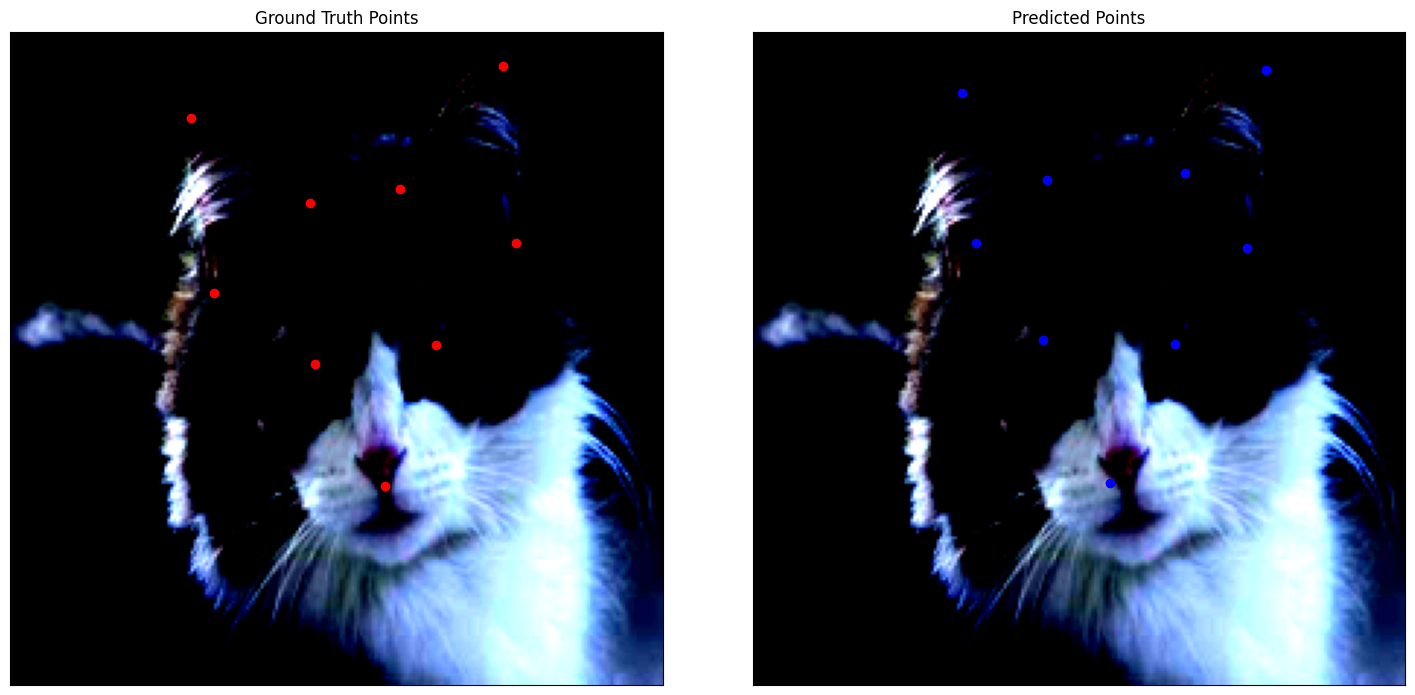

In [40]:
evaluator.plot_random_image()

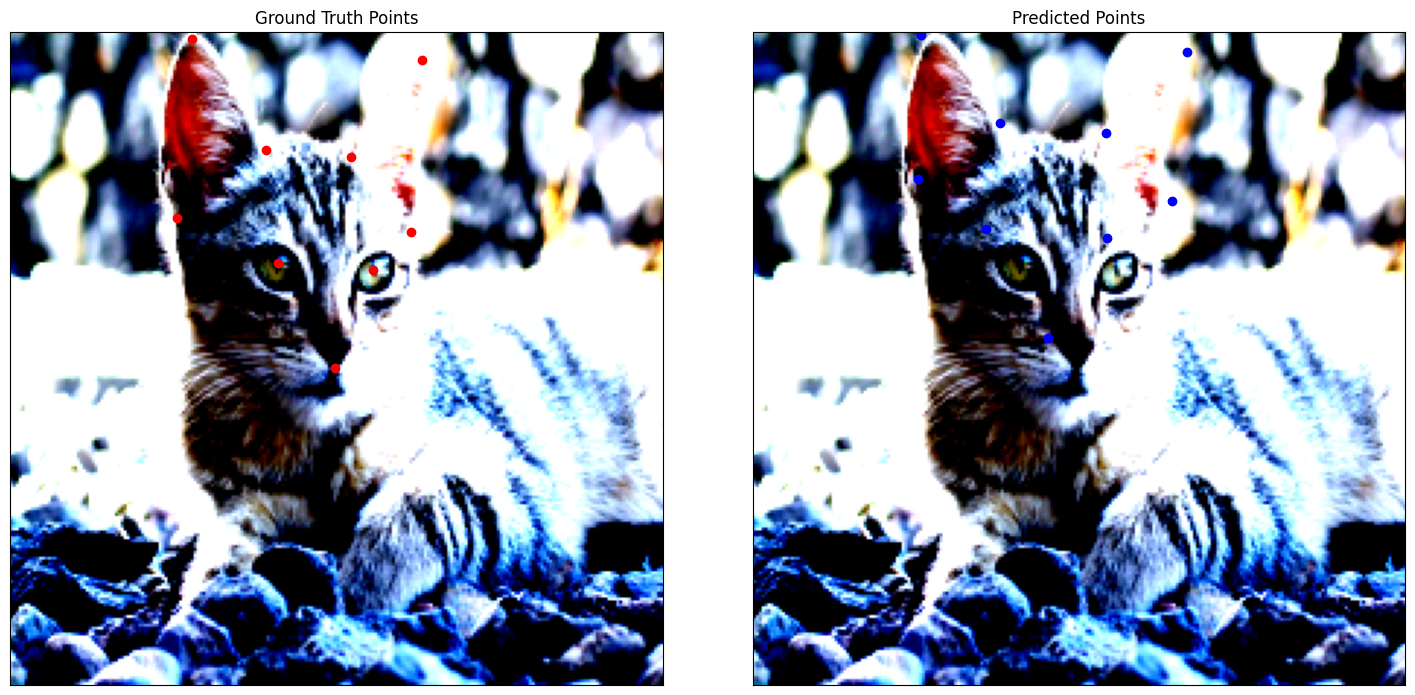

In [32]:
evaluator.plot_random_image()

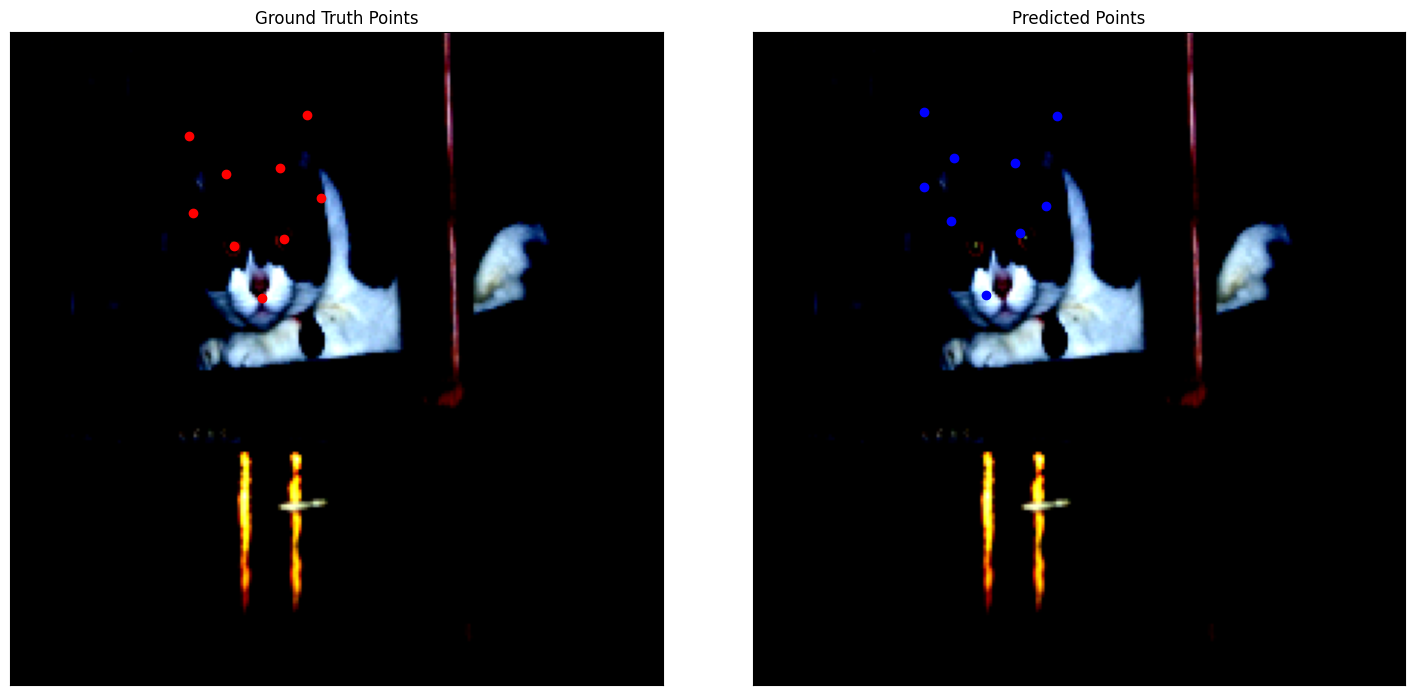

In [41]:
evaluator.plot_random_image()

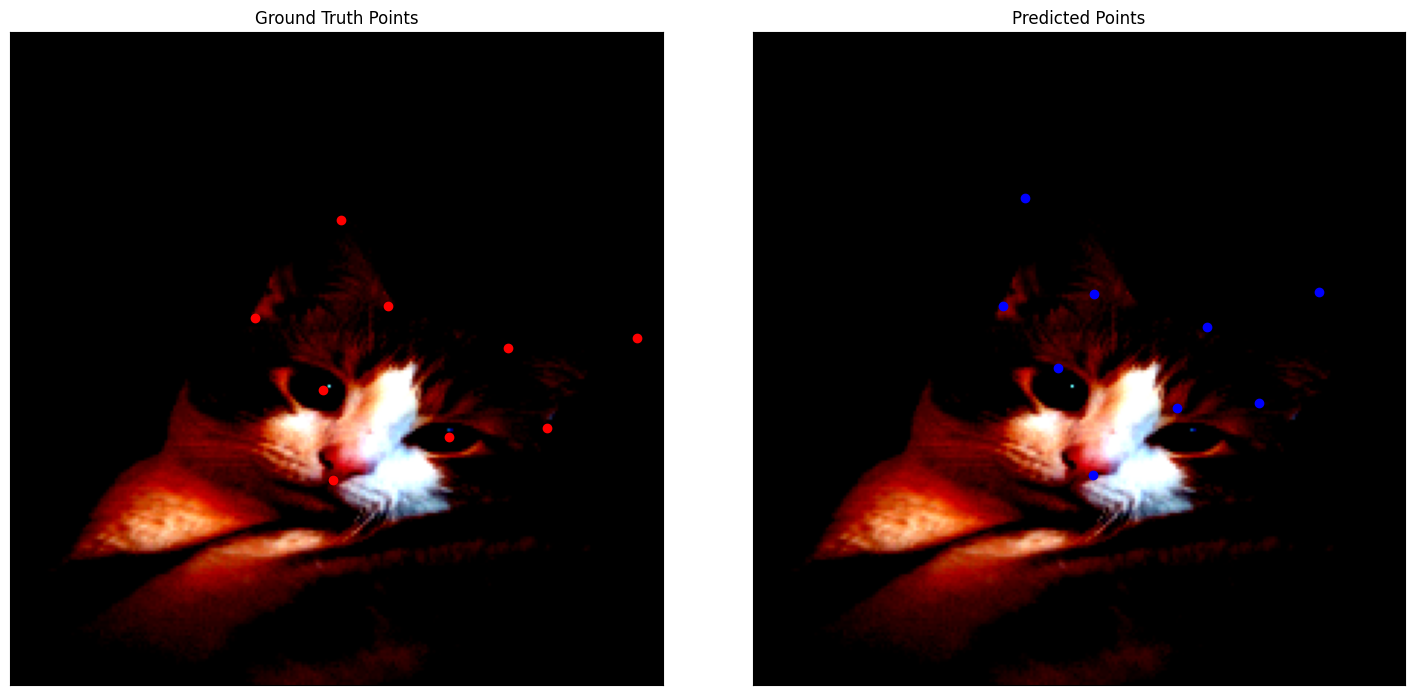

In [44]:
evaluator.plot_random_image()

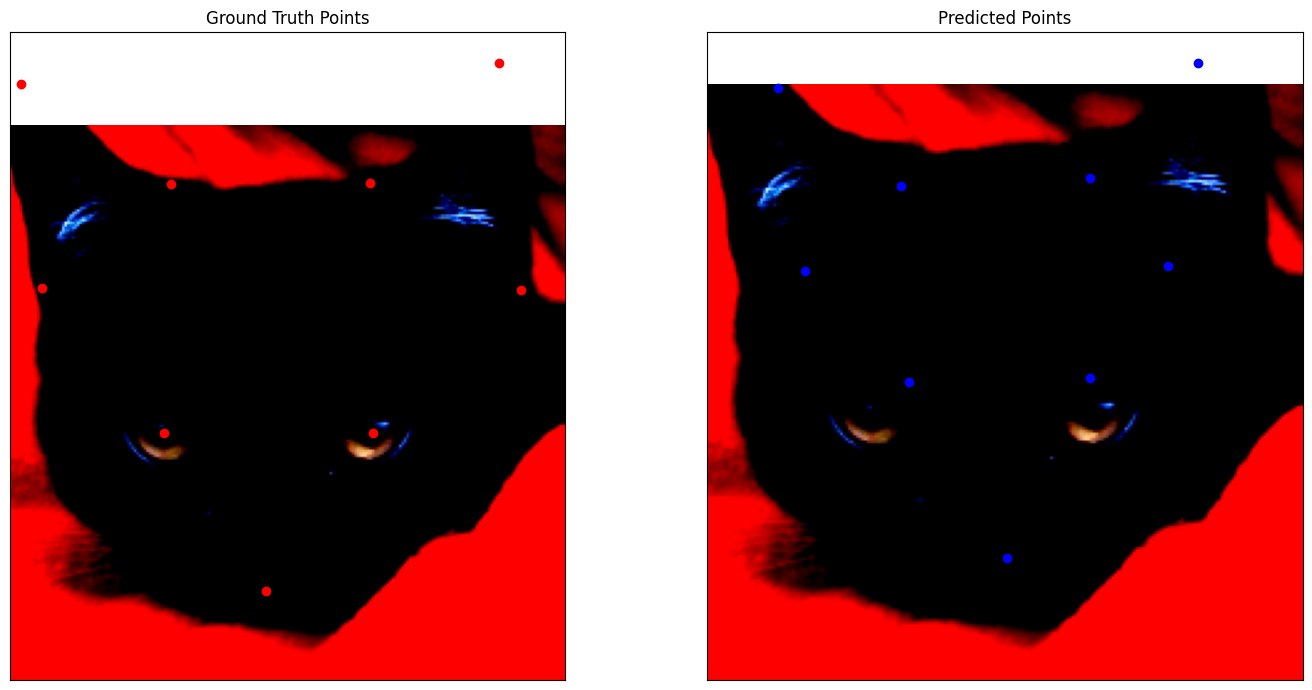

In [50]:
evaluator.plot_random_image()

# Q2

In [58]:
import cv2 as cv

In [59]:
def gaussian(sigma, x, y):
    coefficient = 1 / (np.sqrt(2 * np.pi) * sigma)
    exponent = math.exp(-(x**2 + y**2) / (2 * sigma**2))
    return coefficient * exponent

In [60]:
def generate_gaussian_kernel():
    gaussian_kernel = np.zeros((5, 5))
    for row in range(-2, 3):
        for col in range(-2, 3):
            gaussian_kernel[row + 1, col + 1] = gaussian(1.5, row, col)
    return gaussian_kernel

In [61]:
def lucas_kanade_expand(image):
    width, height = image.shape
    expanded_width = int(width * 2)
    expanded_height = int(height * 2)
    expanded_image = np.zeros((expanded_width, expanded_height))
    expanded_image[::2, ::2] = image
    gaussian_filter = generate_gaussian_kernel()
    for row in range(2, expanded_image.shape[0] - 2, 2):
        for col in range(2, expanded_image.shape[1] - 2, 2):
            expanded_image[row, col] = np.sum(expanded_image[row - 2:row + 3, col - 2:col + 3] * gaussian_filter)
    return expanded_image

In [62]:
def iterative_expand(image_path, levels):
    if levels == 0:
        return image_path
    current_image = cv.imread(image_path, 0)
    for _ in range(levels):
        current_image = lucas_kanade_expand(current_image)
    return current_image

In [63]:
def reduce_image_with_pyramid(image_path, levels):
    original_image = cv.imread(image_path, 0)
    if levels == 0:
        return original_image
    for _ in range(levels):
        width, height = original_image.shape
        reduced_width = int(width / 2)
        reduced_height = int(height / 2)
        gaussian_filter = generate_gaussian_kernel()
        reduced_image = np.ones((reduced_width, reduced_height))
        for row in range(2, original_image.shape[0] - 2, 2):
            for col in range(2, original_image.shape[1] - 2, 2):
                reduced_image[int(row / 2), int(col / 2)] = np.sum(original_image[row - 2:row + 3, col - 2:col + 3] * gaussian_filter)
        original_image = reduced_image
    return original_image

In [64]:
def lucas_kanade_reduce(image):
    width, height = image.shape
    reduced_width = int(width / 2)
    reduced_height = int(height / 2)
    gaussian_filter = generate_gaussian_kernel()
    reduced_image = np.ones((reduced_width, reduced_height))
    for row in range(2, image.shape[0] - 2, 2):
        for col in range(2, image.shape[1] - 2, 2):
            reduced_image[int(row / 2), int(col / 2)] = np.sum(image[row - 2:row + 3, col - 2:col + 3] * gaussian_filter)
    return reduced_image

In [65]:
def iterative_reduce(image_path, levels):
    if levels == 0:
        return image_path
    current_image = cv.imread(image_path, 0)
    for _ in range(levels):
        current_image = lucas_kanade_reduce(current_image)
    return current_image

In [66]:
def lucas_kanade_optical_flow(image1_path, img1, image2_path, img2, levels, operation):
    old_frame = cv.imread(image1_path)
    img1_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
    new_frame = cv.imread(image2_path)

    colors = np.random.randint(0, 255, (100, 3))
    gradient_x = np.array([[-1, 1], [-1, 1]])
    gradient_y = np.array([[-1, -1], [1, 1]])
    temporal_gradient1 = np.array([[-1, -1], [-1, -1]])
    temporal_gradient2 = np.array([[1, 1], [1, 1]])

    ix = (convolve2d(img1, gradient_x) + convolve2d(img2, gradient_x)) / 2
    iy = (convolve2d(img1, gradient_y) + convolve2d(img2, gradient_y)) / 2
    it1 = convolve2d(img1, temporal_gradient1) + convolve2d(img2, temporal_gradient2)

    feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
    features = cv.goodFeaturesToTrack(img1_gray, mask=None, **feature_params)
    features = np.int32(features)

    if operation == "Reduce":
        features = np.int32(features / (2 ** levels))
    else:
        features = np.int32(features * (2 ** levels))

    features = features.reshape(-1, 2)

    u = np.ones(ix.shape)
    v = np.ones(ix.shape)
    status = np.zeros(features.shape[0])
    A_matrix = np.zeros((2, 2))
    B_matrix = np.zeros((2, 1))
    mask = np.zeros_like(old_frame)
    updated_features = np.zeros_like(features)

    for index, point in enumerate(features):
        x, y = point

        A_matrix[0, 0] = np.sum((ix[y - 1:y + 2, x - 1:x + 2]) ** 2)
        A_matrix[1, 1] = np.sum((iy[y - 1:y + 2, x - 1:x + 2]) ** 2)
        A_matrix[0, 1] = np.sum(ix[y - 1:y + 2, x - 1:x + 2] * iy[y - 1:y + 2, x - 1:x + 2])
        A_matrix[1, 0] = np.sum(ix[y - 1:y + 2, x - 1:x + 2] * iy[y - 1:y + 2, x - 1:x + 2])
        A_inv = np.linalg.pinv(A_matrix)

        B_matrix[0, 0] = -np.sum(ix[y - 1:y + 2, x - 1:x + 2] * it1[y - 1:y + 2, x - 1:x + 2])
        B_matrix[1, 0] = -np.sum(iy[y - 1:y + 2, x - 1:x + 2] * it1[y - 1:y + 2, x - 1:x + 2])
        result = np.matmul(A_inv, B_matrix)

        u[y, x] = result[0]
        v[y, x] = result[1]

        updated_features[index] = [np.int32(x + u[y, x]), np.int32(y + v[y, x])]
        if np.int32(x + u[y, x]) == x and np.int32(y + v[y, x]) == y:
            status[index] = 0
        else:
            status[index] = 1

    flipped_u = np.flipud(u)
    flipped_v = np.flipud(v)
    if operation == "Reduce":
        valid_new = np.int32(updated_features[status == 1] * (2 ** levels))
        valid_old = np.int32(features[status == 1] * (2 ** levels))
    else:
        valid_new = np.int32(updated_features[status == 1] / (2 ** levels))
        valid_old = np.int32(features[status == 1] / (2 ** levels))

    for i, (new_point, old_point) in enumerate(zip(valid_new, valid_old)):
        a, b = new_point.ravel()
        c, d = old_point.ravel()
        mask = cv.line(mask, (a, b), (c, d), colors[i].tolist(), 2)
        new_frame = cv.circle(new_frame, (a, b), 5, colors[i].tolist(), -1)
    img = cv.add(new_frame, mask)
    return img


/tmp/ipykernel_34/539719834.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[y, x] = result[0]
/tmp/ipykernel_34/539719834.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[y, x] = result[1]


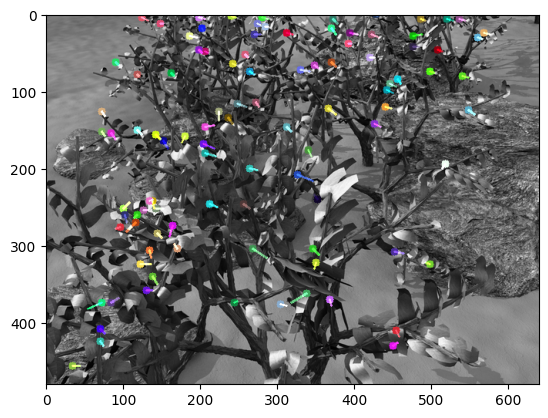

In [67]:
# Reduced Image Pyramid
image1_reduce = iterative_reduce("/kaggle/input/h3-question2/Q2-1.png", 1)
image2_reduce = iterative_reduce("/kaggle/input/h3-question2/Q2-2.png", 1)
final_reduce_image = lucas_kanade_optical_flow("/kaggle/input/h3-question2/Q2-1.png", image1_reduce, "/kaggle/input/h3-question2/Q2-2.png", image2_reduce, 1, "Reduce")
cv.imwrite('final_reduce_image.png', final_reduce_image)
plt.imshow(final_reduce_image)
plt.show()

/tmp/ipykernel_34/539719834.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[y, x] = result[0]
/tmp/ipykernel_34/539719834.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v[y, x] = result[1]


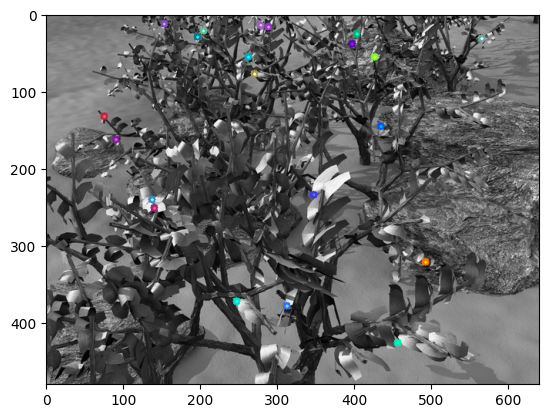

In [68]:
# Expand Image Pyramid
image1_expand = iterative_expand("/kaggle/input/h3-question2/Q2-1.png", 1)
image2_expand = iterative_expand("/kaggle/input/h3-question2/Q2-2.png", 1)
final_expand_image = lucas_kanade_optical_flow("/kaggle/input/h3-question2/Q2-1.png", image1_expand, "/kaggle/input/h3-question2/Q2-1.png", image2_expand, 1, "Expand")
plt.imshow(final_expand_image)
plt.show()